## Trend Analysis (Statistics)

In [3]:
import os
import glob
import pandas as pd 
import json 
import matplotlib.pyplot as plt
import datetime
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))

import string
import regex as re

In [2]:
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

In [5]:
HOME_PATH = "/home/lingjia/raw_data"

## Facebook Data
### Functions

In [6]:
def read_facebook_data():
    df_list = []
    PATH = HOME_PATH + "/Facebook"

    for file in os.listdir(PATH):
        if file.endswith("csv"):
            data = pd.read_csv(os.path.join(PATH,file), sep=";")
            df_list.append(data)
    
    combined_data = pd.concat(df_list)

    return combined_data

In [7]:
def convert_datetime(iso_datetime):
    """[Converts ISO datetime to YYYY-MM-DD format]

    Args:
        iso_datetime (string): [datetime format stored in Facebook]

    Returns:
        [datetime]: [YYYY-MM-DD]
    """
    formatted_datetime = datetime.datetime.strptime(iso_datetime, "%Y-%m-%dT%H:%M:%S%z").date()
    return formatted_datetime

In [14]:
def cleanData(dataframe):
    """[Drops all erroneous records and records without datetime. Datetime for remaining records are formatted using convert_datetime() function]

    Args:
        dataframe ([DataFrame]): [containing all raw records from all Facebook profiles]

    Returns:
        [DataFrame]: [irrelevant columns removed, and added a new column of formatted datetime]
    """
    dropped_data = dataframe[(dataframe["created_time.1"].isnull() == False) & (dataframe["message"].isna() == False)]
    dropped_data = dropped_data[(dropped_data["object_type"] == "data") | dropped_data["query_status"] != "error (400)"]
    
    dropped_data["date_posted"] = dropped_data["created_time.1"].apply(convert_datetime)
    dropped_data["date_posted"] = pd.to_datetime(dropped_data["date_posted"])
    dropped_data = dropped_data.drop(["object_type", "object_key", "query_status", "query_time", "id.1", "from.id", "from.name", "created_time", "permalink_url", "created_time.1"], axis=1)
    
    og_num_rows = len(dataframe)
    dropped_num_data = len(dropped_data)
    print(f"Before: {og_num_rows} \n After: {dropped_num_data}")
    
    return dropped_data

In [9]:
def aggregate_by_date(dataframe, date_range):
    idx = pd.date_range(date_range[0], date_range[1])

    # Getting posts
    posts_df = dataframe[dataframe["query_type"] == "Facebook:/<page-id>/posts"]
    post_frequency_df = (posts_df.groupby('date_posted').size()
                        .reset_index(name='post_frequency')
                        )
    post_frequency_df.set_index("date_posted", drop=True, inplace=True)
    post_frequency_by_date = post_frequency_df.reindex(idx, fill_value=0)

        # Engagement metrics for post
    post_metric_df = (posts_df.groupby('date_posted')['shares.count',"like.summary.total_count", "reactions.summary.total_count"].sum()
                    .reset_index()
                    .rename({'shares.count':'num_shares',
                            'like.summary.total_count':'num_likes',
                            'reactions.summary.total_count':'num_reactions'}, axis='columns')
                    )
    post_metric_df.set_index("date_posted", drop=True, inplace=True)
    post_metrics_by_date = post_metric_df.reindex(idx, fill_value=0)

    # Getting comments on posts
    comments_df = dataframe[dataframe["query_type"] == "Facebook:/<post-id>/comments"]
    comments_frequency_df = (comments_df.groupby('date_posted').size()
                            .reset_index(name='comment_frequency')
                            )
    comments_frequency_df.set_index("date_posted", drop=True, inplace=True)
    comment_frequency_by_date = comments_frequency_df.reindex(idx, fill_value=0)

    comment_metric_df = (comments_df.groupby('date_posted')['shares.count',"like.summary.total_count", "reactions.summary.total_count"].sum()
                    .reset_index()
                    .rename({'shares.count':'num_shares',
                            'like.summary.total_count':'num_likes',
                            'reactions.summary.total_count':'num_reactions'}, axis='columns')
                    )
    comment_metric_df.set_index("date_posted", drop=True, inplace=True)
    comment_metrics_by_date = comment_metric_df.reindex(idx, fill_value=0)
    
    return post_frequency_by_date, post_metrics_by_date, comment_frequency_by_date, comment_metrics_by_date

In [10]:
def plot_timeseries_1(df, title):
    df.plot()
    
    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()

def plot_timeseries_2(df1, df2, y, title):
    # Plotting frequency of comments and posts over time on the same line graph 
    ax = df1.plot(y=y)
    df2.plot(ax=ax)

    plt.xticks(rotation=45)
    plt.title(title)
    plt.show()

In [11]:
def text_preprocessing(text):
    # punctuations = string.punctuation
    wnl = WordNetLemmatizer()

    lowercase_text = text.lower()
    punctuations_removed = re.sub('[^a-z0-9]', ' ', lowercase_text)
    # table = str.maketrans('','', punctuations)
    # punctuations_removed = lowercase_text.translate(table)
    tokens = word_tokenize(punctuations_removed)
    stopwords_removed = [token for token in tokens if token not in stop_words]
    lemmatized_output = ' '.join([wnl.lemmatize(w) for w in stopwords_removed])

    return lemmatized_output

In [12]:
def get_text(df):
    text_df = df[["message", "date_posted"]]
    text_df["text_processed"] = text_df["message"].apply(text_preprocessing)
    return text_df

### Testing 

In [15]:
# profiles = ["mothership", "mustsharenews", "stomp"]
# combined_data = combine_facebook_data(profiles)

combined_data = read_facebook_data()
clean_combined_data = cleanData(combined_data)
# post_frequency_by_date, post_metrics_by_date, comment_frequency_by_date, comment_metrics_by_date = aggregate_by_date(clean_combined_data, ("2018-01-05", "2019-05-01"))
# plot_timeseries_1(comment_metrics_by_date, "Engagement metrics for comments over time")
# plot_timeseries_1(post_metrics_by_date, "Engagement metrics for posts over time")
# plot_timeseries_2(post_frequency_by_date, comment_frequency_by_date, "post_frequency", "Frequency of posts/comments over time")

/tmp/ipykernel_233994/2519420702.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(PATH,file), sep=";")
/tmp/ipykernel_233994/2519420702.py:7: DtypeWarning: Columns (2,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(PATH,file), sep=";")
/tmp/ipykernel_233994/2519420702.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(PATH,file), sep=";")
/tmp/ipykernel_233994/2519420702.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(PATH,file), sep=";")
/tmp/ipykernel_233994/2519420702.py:7: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join(PATH,file), sep=";")
/tmp/ipykernel_233994

Before: 2753391 
 After: 2280725


In [17]:
clean_combined_data.head(5)

,path,id,parent_id,level,object_id,query_type,message,picture,full_picture,shares.count,...,like.summary.total_count,love.summary.total_count,haha.summary.total_count,wow.summary.total_count,sad.summary.total_count,angry.summary.total_count,comment_count,like_count,comments.summary.total_count.1,date_posted
1,144053245626126/144053245626126_1809114542453313,624005,624004,1,144053245626126_1809114542453313,Facebook:/<page-id>/posts,"Before the days of Internet dating, there was ...",NaN,NaN,NaN,...,27.0,3.0,0.0,2.0,0.0,0.0,NaN,NaN,5.0,2018-01-30
2,144053245626126/144053245626126_18091145424533...,627699,624005,2,144053245626126_1809114542453313,Facebook:/<post-id>/comments,Who loves love stories too? 🙋‍♀️🙋‍♂️,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-30
3,144053245626126/144053245626126_18091145424533...,627700,624005,2,144053245626126_1809114542453313,Facebook:/<post-id>/comments,Wahhhh Bari not bad u famous liao,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-30
4,144053245626126/144053245626126_18091145424533...,627701,624005,2,144053245626126_1809114542453313,Facebook:/<post-id>/comments,god bless both of you. inspirational story,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2018-01-30
7,144053245626126/144053245626126_1809091019122332,624006,624004,1,144053245626126_1809091019122332,Facebook:/<page-id>/posts,"Man, allegedly high on drugs, tackled by polic...",NaN,NaN,NaN,...,115.0,2.0,20.0,12.0,1.0,3.0,NaN,NaN,33.0,2018-01-30


In [18]:
clean_combined_data.to_csv("/home/lingjia/raw_data/Facebook/combined_data.csv")

In [16]:
post_metrics_by_date

,num_shares,num_likes,num_reactions
2018-01-05,40.0,860.0,1580.0
2018-01-06,8.0,2117.0,2760.0
2018-01-07,31.0,536.0,957.0
2018-01-08,1233.0,5858.0,9810.0
2018-01-09,22.0,2090.0,3150.0
2018-01-10,295.0,1165.0,1891.0
2018-01-11,48.0,2862.0,4526.0
2018-01-12,78.0,577.0,1024.0
2018-01-13,27.0,385.0,863.0
2018-01-14,20.0,1990.0,2413.0


In [16]:
text = get_text(clean_combined_data)
text["processed_text"] = text["message"].apply(text_preprocessing)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
text = pd.read_csv("C:/Users/user/Downloads/fyp test eda/processed_facebok_text.csv")
text

,Unnamed: 0,message,date_posted,processed_text
0,1,Embrace hail in Singapore. Just let it go.,2018-01-30,embrace hail singapore let go
1,2,Background music superb tok Kong. No horse run.,2018-01-31,background music superb tok kong horse run
2,3,hail stones hitting a moving car unexpectedly ...,2018-01-31,hail stone hitting moving car unexpectedly dau...
3,4,Ya y no drop money drop ice cubes.,2018-01-31,ya drop money drop ice cube
4,5,Ur BGM sibei irritating can,2018-01-31,ur bgm sibei irritating
...,...,...,...,...
796387,326778,Insane in the membrane,2021-12-01,insane membrane
796388,326779,Straight people are normal people ? All mother...,2021-12-01,straight people normal people mother love
796389,326780,They can massage all they want inside the cell...,2021-12-01,massage want inside cell soon
796390,326781,Both(mum n idiot) are very Sick. Jail both for...,2021-12-01,mum n idiot sick jail 20 year let die inside good


## YouTube Data
### Functions

In [18]:
def read_youtube_data():
    accounts_df = pd.DataFrame()
    comments_df = pd.DataFrame()

    PATH = HOME_PATH + "/YouTube"

    for file in os.listdir(PATH):
        if file.startswith("account"):
            with open(os.path.join(PATH,file), encoding='utf-8') as f:
                data = json.load(f)
                for user in data:
                    for video in data[user]:
                        video["user"] = user
                        accounts_df = accounts_df.append(video, ignore_index=True)

        else:
            with open(os.path.join(PATH,file), encoding='utf-8') as f:
                data = json.load(f)
                for user in data:
                    for video_details in data[user]:
                        video_details["user"] = user
                        comments_df = comments_df.append(video_details, ignore_index=True)

    accounts_df.rename(columns={'Title':'video_title', 
                                'URL':'video_url', 
                                'Thumbnail':'video_thumbnail'},
                        inplace=True)

    comments_df.rename(columns={'Title':'video_title', 
                                'Views':'num_views', 
                                'Date Uploaded':'date_uploaded', 
                                'Likes':'num_likes', 
                                'Description':'description', 
                                'Comments':'comments_list'},
                        inplace=True)

    combined_data = accounts_df.merge(comments_df, on=['user', 'video_title'])
    return combined_data

In [19]:
def clean_youtube_data(df):
    df["num_likes"] = df["num_likes"].apply(convert_likes)
    df["num_views"] = df["num_views"].apply(convert_views)
    df["num_comments"] = df["comments_list"].apply(num_comments)
    df["num_videos"] = 1

    return df

In [20]:
def convert_likes(text):
    if "K" in text:
        text = float(text[:-1])*1000
    else:
        text = text
    return int(text)

def convert_views(text):
    num = text.split()[0].replace(",", "")
    return int(num)

def num_comments(list):
    num_comments = len(list)
    return num_comments

In [21]:
def aggregate_youtube_metrics(df, date_range):
    idx = pd.date_range(date_range[0], date_range[1])

    aggregate_metrics = df.groupby("date_uploaded")["num_likes", "num_views", "num_comments", "num_videos"].sum()
    aggregate_metrics.reset_index(inplace=True)

    aggregate_metrics.index = pd.DatetimeIndex(aggregate_metrics["date_uploaded"])
    aggregate_metrics.drop(["date_uploaded"], axis=1, inplace=True)
    aggregate_metrics =  aggregate_metrics.reindex(idx, fill_value=0)

    return aggregate_metrics

### Testing

In [22]:
combined_youtube_data = read_youtube_data()
combined_youtube_data

,video_thumbnail,video_title,video_url,user,comments_list,date_uploaded,description,num_likes,num_views
0,https://i.ytimg.com/vi/Tj3rTmLg-4o/hqdefault.j...,Advice From The Big Brother You Never Had,https://www.youtube.com/watch?v=Tj3rTmLg-4o,SneakySushii,[The merch is something i would wear daily.. i...,"Jan 30, 2022",I give good life advice. \n\nSneaky Sushii Off...,4.4K,"98,307 views"
1,https://i.ytimg.com/vi/3YpW4H0ryWg/hqdefault.j...,It's Time I Addressed This Issue.,https://www.youtube.com/watch?v=3YpW4H0ryWg,SneakySushii,"[I was having a bad day, and this video made m...","Jan 23, 2022",I'm not your kor kor.\n\nSneaky Sushii Officia...,5K,"133,107 views"
2,https://i.ytimg.com/vi/1WWUOBD9elA/hqdefault.j...,TikTok Girlfriend For Rent On Chinese New Year,https://www.youtube.com/watch?v=1WWUOBD9elA,YEOLO,[],"Jan 31, 2022",Subscribe: Instagram: Twitter:,659,"21,444 views"
3,https://i.ytimg.com/vi/XCEanYW_ICU/hqdefault.j...,This Creepy Guy Needs To Stop,https://www.youtube.com/watch?v=XCEanYW_ICU,YEOLO,[sentosa guy didn't pass the vibe check\nhttp:...,"Jan 24, 2022",Subscribe: Instagram: Twitter:,1K,"37,369 views"


In [23]:
cleaned_yt_data = clean_youtube_data(combined_youtube_data)
cleaned_yt_data

,video_thumbnail,video_title,video_url,user,comments_list,date_uploaded,description,num_likes,num_views,num_comments,num_videos
0,https://i.ytimg.com/vi/Tj3rTmLg-4o/hqdefault.j...,Advice From The Big Brother You Never Had,https://www.youtube.com/watch?v=Tj3rTmLg-4o,SneakySushii,[The merch is something i would wear daily.. i...,"Jan 30, 2022",I give good life advice. \n\nSneaky Sushii Off...,4400,98307,220,1
1,https://i.ytimg.com/vi/3YpW4H0ryWg/hqdefault.j...,It's Time I Addressed This Issue.,https://www.youtube.com/watch?v=3YpW4H0ryWg,SneakySushii,"[I was having a bad day, and this video made m...","Jan 23, 2022",I'm not your kor kor.\n\nSneaky Sushii Officia...,5000,133107,384,1
2,https://i.ytimg.com/vi/1WWUOBD9elA/hqdefault.j...,TikTok Girlfriend For Rent On Chinese New Year,https://www.youtube.com/watch?v=1WWUOBD9elA,YEOLO,[],"Jan 31, 2022",Subscribe: Instagram: Twitter:,659,21444,0,1
3,https://i.ytimg.com/vi/XCEanYW_ICU/hqdefault.j...,This Creepy Guy Needs To Stop,https://www.youtube.com/watch?v=XCEanYW_ICU,YEOLO,[sentosa guy didn't pass the vibe check\nhttp:...,"Jan 24, 2022",Subscribe: Instagram: Twitter:,1000,37369,64,1


In [24]:
aggregated_youtube_data = aggregate_youtube_metrics(cleaned_yt_data, ('2022-01-20', '2022-01-31'))
aggregated_youtube_data

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.


,num_likes,num_views,num_comments,num_videos
2022-01-20,0,0,0,0
2022-01-21,0,0,0,0
2022-01-22,0,0,0,0
2022-01-23,5000,133107,384,1
2022-01-24,1000,37369,64,1
2022-01-25,0,0,0,0
2022-01-26,0,0,0,0
2022-01-27,0,0,0,0
2022-01-28,0,0,0,0
2022-01-29,0,0,0,0


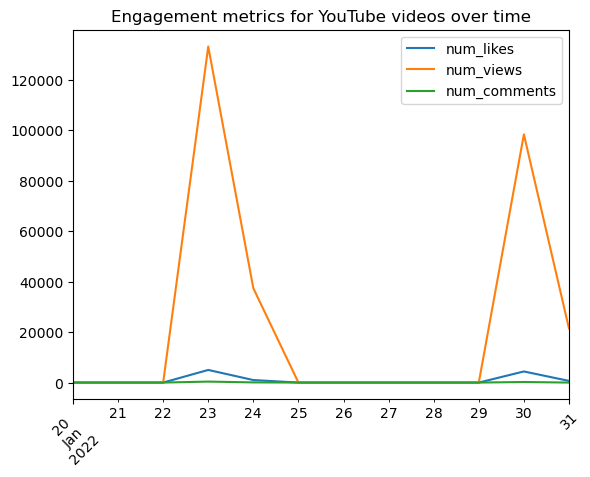

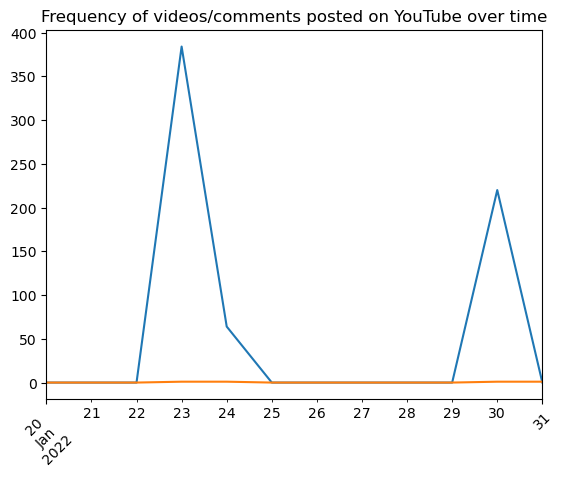

In [25]:
plot_timeseries_1(aggregated_youtube_data.iloc[:, 0:3], "Engagement metrics for YouTube videos over time")
plot_timeseries_2(aggregated_youtube_data["num_comments"], aggregated_youtube_data["num_videos"], aggregated_youtube_data.index, "Frequency of videos/comments posted on YouTube over time")

## Reddit Data
### Functions

In [144]:
def read_reddit_data():
    PATH = HOME_PATH + "/Reddit/reddit_historical_data"
    posts_df = pd.DataFrame()
    comment_df = pd.DataFrame()

    for file in os.listdir(PATH):
        if file.endswith(".json"):
            with open(os.path.join(PATH, file), encoding='utf-8') as f:
                data = json.load(f)
                for post in data:
                    data_list = []
                    post_id = post
                    author_id = data[post]["author_fullname"]
                    post_title = data[post]["title"]
                    # link_flair = data[post][0]["t"]
                    upvote_ratio = data[post]["upvote_ratio"]
                    num_upvotes = data[post]["ups"]
                    num_awards = data[post]["total_awards_received"]
                    media = data[post]["media_embed"]
                    thumbnail = data[post]["thumbnail"]
                    num_views = data[post]["view_count"]
                    is_over18 = data[post]["over_18"]
                    awards_list = data[post]["all_awardings"]
                    author_name = data[post]["author"]
                    num_comments = data[post]["num_comments"]
                    post_url = data[post]["permalink"]
                    created_date = data[post]["created_utc"]
                    
                    comment_df = comment_df.append(data[post]["comments"], ignore_index=True)

                    data_list.append([post_id, author_id, post_title, upvote_ratio, num_upvotes, num_awards, media, thumbnail, num_views, is_over18, awards_list, author_name, num_comments, post_url, created_date])

                    posts_df = posts_df.append(data_list, ignore_index=True)

    return posts_df, comment_df

In [145]:
# posts, comments = read_reddit_data()
posts

In [117]:
def extract_reddit_data(data):
    for post_id in data:
        post_dict = {
            variable: data[post_id].get(variable)
            for variable in REDDIT
            if variable != 'comments'
        }

        if comment== data[post_id]['comments']:
            for cid in comments:
                comment_dict = {
                    comment_variable: comments[cid].get(comment_variable)
                    for comment_variable in REDDIT_COMMENT
                }
                # Change dictionary key name to be consistent with dynamodb table
                comment_dict['post_id'] = comment_dict.pop('_submission')
    return post_dict, comment_dict

REDDIT = [
    'author_fullname', 
    'title', 
    'link_flair_text', 
    'downs', 
    'ups', 
    'upvote_ratio', 
    'score', 
    'is_original_content', 
    'created', 
    'top_awarded_type', 
    'id', 
    'permalink', 
    'num_comments', 
    'media_embed', 
    'thumbnail', 
    'view_count', 
    'over_18', 
    'preview', 
    'author', 
    'all_awardings', 
    'discussion_type', 
    'created_utc', 
    'body_html',
    'comments'
]

REDDIT_COMMENT = [
    'comment_type',
    'total_awards_received',
    'likes',
    'author',
    'created_utc',
    '_submission',
    'score',
    'body',
    'downs',
    'top_awarded_type',
    'permalink',
    'ups',
    'score_hidden',
    'depth',
    'parent_id',
    'id'
]

## Twitter Data
### Functions